# Simple Customer Insights
_version 0.3_


## Overview

Today, an ever growing wealth of public data, e.g. census, geospatial, demographic, incident, traffic, etc., is available to fuel analytic insights directly or in combination with corporate data. Your own data only tells you what your business is doing. With open data, you learn what the world is doing. And the combination of the two allows you to align business practices with the market.

**Simple Customer Insights** is about democratizing big data analytics with open data and cloud-based analytics. It's a [Jupyter notebook](http://jupyter.org/) that runs best in [IBM's Spark-as-a-service](http://www.ibm.com/analytics/us/en/technology/cloud-data-services/spark-as-a-service/) that enables a Bluemix user to integrate customer sales data with US Census demographic data, and in minutes perform common analyses that once took days or weeks to complete.

This notebook goes through a complete analysis using sample data readily available on the web. But it also serves as a template for your own work with your own data. Just substitute the sample sales data with your own! 

Here are some of the insights produced in this notebook:
1. demographic characteristics of good customers
1. most important demographic characteristics in understanding product appeal
1. location of places that are like those areas currently enjoying strong sales



## Setup 

Import libraries and connection information to connect to Swift Object Storage on IBM Bluemix to get data from CSV text files. 

In [1]:
import os, requests, StringIO, pandas as pd, numpy as np, json, matplotlib.pyplot as plt, seaborn as sns

/Users/rajrsingh/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### ObjectStore credentials

My working environment is set up to get my ObjectStore credentials from variables I've set at the operating system level. You may want to go a simpler route and just enter the values as strings here. You can find your ObjectStore credentials by finding your instance of the ObjectStore service in Bluemix and clicking on the 'Service Credentials'.

![ObjectStore credentials](./img/objectstore_creds.png "ObjectStore credentials")

In [3]:
credentials = {}
credentials['auth_url'] = 'https://identity.open.softlayer.com'
credentials['user_id'] = os.environ['OBJECTSTORE_USER_ID']
credentials['domain_id'] = os.environ['OBJECTSTORE_DOMAIN_ID']
credentials['username'] = os.environ['OBJECTSTORE_USERNAME']
credentials['password'] = os.environ['OBJECTSTORE_PASSWORD']
credentials['container'] = os.environ['OBJECTSTORE_CONTAINER']

In [4]:
# A function returning a StringIO object containing text file content from Object Storage.

def getFileContent(credentials):
    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()    
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                if(e2['interface']=='public'):
                    url2 = ''.join([e2['url'],'/', credentials['container'], '/', credentials['filename']])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO.StringIO(resp2.content)

## Census data

Census data from the 2013 US Census American Community Survey (ACS), 5-year estimates. 

Created from the "zip code tabulation area" (ZCTA) [TIGER/Line® with Selected Demographic and Economic Data product in Geodatabase format](http://www.census.gov/geo/maps-data/data/tiger-data.html). This particular version of the ACS is used for the folowing reasons:
1. 5-year estimates are the most accurate data outside of the decennial census [as explained here](http://www.census.gov/programs-surveys/acs/guidance/estimates.html).
1. 2013 is the most recent data set with 5-year estimates
1. TIGER/Line® gives you the geographic boundaries of the zip codes so you can perform spatial analyses
1. This data set is smaller than the full Census, but still has the important income, education, race, age and occupation demographics we want to use.

If you want to do this yourself, [this article](https://developer.ibm.com/clouddataservices/2015/09/08/census-open-data-on-ibm-cloud/) explains how to get a CSV out of that format. 

### Import household income

In [5]:
credentials['filename'] = 'x19_income.csv'
raw_data = getFileContent(credentials)

income_df = pd.read_csv(raw_data, usecols=['GEOID','B19049e1'])
income_df.columns=['GEOID','INCOME']
income_df = income_df.set_index('GEOID')
income_df.head()

,INCOME
GEOID,
86000US01001,58733
86000US01002,54422
86000US01003,NaN
86000US01005,68644
86000US01007,71875


### Import median ages

In [6]:
credentials['filename'] = 'x01_age_sex.csv'
raw_data = getFileContent(credentials)
age_df = pd.read_csv(raw_data, usecols=['GEOID','B01002e1'])
age_df.columns=['GEOID','AGE']
age_df = age_df.set_index('GEOID')
age_df.head()

,AGE
GEOID,
86000US01001,43.7
86000US01002,22.9
86000US01003,19.9
86000US01005,42.2
86000US01007,41.3


### Merge income and age

In [7]:
census_df = income_df.join(age_df)
census_df.head(4)

,INCOME,AGE
GEOID,,
86000US01001,58733,43.7
86000US01002,54422,22.9
86000US01003,NaN,19.9
86000US01005,68644,42.2


### Import educational attainment for people over 25

In [8]:
credentials['filename'] = 'x15_education.csv'
raw_data = getFileContent(credentials)
edu_df = pd.read_csv(raw_data, 
                     usecols=['GEOID','B15003e1','B15003e2','B15003e3','B15003e4','B15003e5','B15003e6','B15003e7','B15003e8','B15003e9','B15003e10','B15003e11','B15003e12','B15003e13','B15003e14','B15003e15','B15003e16','B15003e17','B15003e18','B15003e19','B15003e20','B15003e21','B15003e22','B15003e23','B15003e24','B15003e25'])


Group educational attainment into 4 major categories, and normalize by making it a percentage of the zip code's population

In [9]:
edu_df['NOHSDIP'] = (edu_df['B15003e2']+edu_df['B15003e3']+edu_df['B15003e4']+edu_df['B15003e5']+edu_df['B15003e6']+edu_df['B15003e7']+edu_df['B15003e8']+edu_df['B15003e9']+edu_df['B15003e10']+edu_df['B15003e11']+edu_df['B15003e12']+edu_df['B15003e13']+edu_df['B15003e14']+edu_df['B15003e15']+edu_df['B15003e16'])/edu_df['B15003e1']
edu_df['HSDIPSOMECOL'] = (edu_df['B15003e17']+edu_df['B15003e18']+edu_df['B15003e19']+edu_df['B15003e20']+edu_df['B15003e21'])/edu_df['B15003e1']
edu_df['BA'] = edu_df['B15003e22']/edu_df['B15003e1']
edu_df['GRAD'] = (edu_df['B15003e23']+edu_df['B15003e24']+edu_df['B15003e25'])/edu_df['B15003e1']
edu_df.drop(['B15003e1','B15003e2','B15003e3','B15003e4','B15003e5','B15003e6','B15003e7','B15003e8','B15003e9','B15003e10','B15003e11','B15003e12','B15003e13','B15003e14','B15003e15','B15003e16','B15003e17','B15003e18','B15003e19','B15003e20','B15003e21','B15003e22','B15003e23','B15003e24','B15003e25'],inplace=True,axis=1)
edu_df = edu_df.set_index('GEOID')
edu_df.head()

,NOHSDIP,HSDIPSOMECOL,BA,GRAD
GEOID,,,,
86000US01001,0.085286,0.661271,0.157284,0.096158
86000US01002,0.043593,0.284836,0.241165,0.430406
86000US01003,0.000000,0.656652,0.210300,0.133047
86000US01005,0.083924,0.681032,0.154239,0.080805
86000US01007,0.065673,0.547798,0.234248,0.152281


### Merge education to other census

In [10]:
census_df = census_df.join(edu_df)
census_df.head()

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD
GEOID,,,,,,
86000US01001,58733,43.7,0.085286,0.661271,0.157284,0.096158
86000US01002,54422,22.9,0.043593,0.284836,0.241165,0.430406
86000US01003,NaN,19.9,0.000000,0.656652,0.210300,0.133047
86000US01005,68644,42.2,0.083924,0.681032,0.154239,0.080805
86000US01007,71875,41.3,0.065673,0.547798,0.234248,0.152281


### Import Race

In [11]:
credentials['filename'] = 'x02_race.csv'
raw_data = getFileContent(credentials)
race_df = pd.read_csv(raw_data, 
                     usecols=['GEOID','B02001e1','B02001e2','B02001e3','B02001e4','B02001e5','B02001e6','B02001e7','B02001e8'])
race_df = race_df.set_index('GEOID')

# Need to get Hispanic from another file
credentials['filename'] = 'x03_hispanic_or_latino.csv'
raw_data = getFileContent(credentials)
hisp_df = pd.read_csv(raw_data, usecols=['GEOID','B03001e3'])
hisp_df = hisp_df.set_index('GEOID')
race_df = race_df.join(hisp_df)

# Normalize race by making it a percentage of the zip code's population
race_df['WHITE'] = race_df['B02001e2']/race_df['B02001e1']
race_df['BLACK'] = race_df['B02001e3']/race_df['B02001e1']
race_df['NATAMER'] = race_df['B02001e4']/race_df['B02001e1']
race_df['ASIAN'] = race_df['B02001e5']/race_df['B02001e1']
race_df['PACISL'] = race_df['B02001e6']/race_df['B02001e1']
race_df['OTHERRACE'] = race_df['B02001e7']/race_df['B02001e1']
race_df['MULTIRACE'] = race_df['B02001e8']/race_df['B02001e1']
race_df['HISPLAT'] = race_df['B03001e3']/race_df['B02001e1']
race_df.drop(['B02001e1','B02001e2','B02001e3','B02001e4','B02001e5','B02001e6','B02001e7','B02001e8','B03001e3'],inplace=True,axis=1)
race_df.head()

,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
GEOID,,,,,,,,
86000US01001,0.922586,0.011772,0.001392,0.027022,0.001566,0.025515,0.010148,0.053291
86000US01002,0.807046,0.044728,0.004271,0.108351,0.000000,0.005023,0.030582,0.075856
86000US01003,0.810642,0.060914,0.000000,0.110950,0.001360,0.006617,0.009518,0.049130
86000US01005,0.976662,0.003361,0.001120,0.018857,0.000000,0.000000,0.000000,0.015310
86000US01007,0.932325,0.017651,0.000000,0.023308,0.000000,0.004634,0.022081,0.029783


### Merge race to other census

In [12]:
census_df = census_df.join(race_df)
census_df.head()

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
GEOID,,,,,,,,,,,,,,
86000US01001,58733,43.7,0.085286,0.661271,0.157284,0.096158,0.922586,0.011772,0.001392,0.027022,0.001566,0.025515,0.010148,0.053291
86000US01002,54422,22.9,0.043593,0.284836,0.241165,0.430406,0.807046,0.044728,0.004271,0.108351,0.000000,0.005023,0.030582,0.075856
86000US01003,NaN,19.9,0.000000,0.656652,0.210300,0.133047,0.810642,0.060914,0.000000,0.110950,0.001360,0.006617,0.009518,0.049130
86000US01005,68644,42.2,0.083924,0.681032,0.154239,0.080805,0.976662,0.003361,0.001120,0.018857,0.000000,0.000000,0.000000,0.015310
86000US01007,71875,41.3,0.065673,0.547798,0.234248,0.152281,0.932325,0.017651,0.000000,0.023308,0.000000,0.004634,0.022081,0.029783


### Summary statistics for Census data

In [13]:
summary_df = census_df.describe(percentiles=[0.4,0.5,0.6])
summary_df = summary_df.drop(summary_df.index[[0,2]])
summary_df

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
mean,52112.585863,41.495351,0.142982,0.635888,0.141745,0.079385,0.841515,0.076411,0.017566,0.019763,0.001062,0.021783,0.021899,0.084829
min,2499.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40%,43864.000000,39.400000,0.098551,0.629885,0.101979,0.044529,0.888687,0.003023,0.000000,0.000000,0.000000,0.000000,0.009633,0.016256
50%,47778.000000,41.100000,0.118819,0.658076,0.120989,0.055047,0.929005,0.008680,0.000930,0.002520,0.000000,0.002613,0.013994,0.026227
60%,52031.000000,42.900000,0.143008,0.683938,0.142688,0.067751,0.954310,0.019099,0.002237,0.005837,0.000000,0.006331,0.018782,0.040488
max,250001.000000,91.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.610088,1.000000,1.000000,1.000000


### Examining correlation

In this section, we take a quick look at the correlation coefficients of many of our variables of interest to make sure it's worth looking at each one separately. This function computes the [Pearson product-moment correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient), which looks at two variables and computes a number between -1 and 1, where -1 is perfect negative correlation, 1 is perfect positive correlation, and 0 is no correlation. 

None of our variables of interest have a particularly strong correlation with each other (except for the obvious ones like income with bachelor's (BA) or graduate degree (GRAD)), so we can proceed with analysis knowing that it's worth looking at all of them. 

In [14]:
census_df.corr()

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
INCOME,1.000000,0.019283,-0.493704,-0.403501,0.612801,0.608495,0.133290,-0.198328,-0.105948,0.316532,0.007710,-0.056600,0.013031,-0.059277
AGE,0.019283,1.000000,-0.132785,0.101687,-0.012931,0.014904,0.343371,-0.202765,-0.135526,-0.157964,-0.041132,-0.233473,-0.139086,-0.285101
NOHSDIP,-0.493704,-0.132785,1.000000,-0.188873,-0.494164,-0.393269,-0.271457,0.222353,0.097679,-0.094619,-0.008707,0.308963,-0.006511,0.374778
HSDIPSOMECOL,-0.403501,0.101687,-0.188873,1.000000,-0.647732,-0.679238,0.200404,-0.086157,0.043879,-0.363412,-0.007114,-0.201873,-0.049185,-0.243569
BA,0.612801,-0.012931,-0.494164,-0.647732,1.000000,0.554777,0.025670,-0.084107,-0.102451,0.336811,0.017371,-0.030838,0.044005,-0.032637
GRAD,0.608495,0.014904,-0.393269,-0.679238,0.554777,1.000000,-0.016970,-0.043357,-0.079743,0.338609,0.002832,-0.022916,0.039553,-0.035593
WHITE,0.133290,0.343371,-0.271457,0.200404,0.025670,-0.016970,1.000000,-0.762096,-0.396899,-0.333107,-0.138006,-0.355111,-0.303079,-0.253063
BLACK,-0.198328,-0.202765,0.222353,-0.086157,-0.084107,-0.043357,-0.762096,1.000000,-0.062498,0.015115,-0.019454,0.054918,0.004964,0.019785
NATAMER,-0.105948,-0.135526,0.097679,0.043879,-0.102451,-0.079743,-0.396899,-0.062498,1.000000,-0.036464,0.018238,-0.023622,0.093660,-0.025517
ASIAN,0.316532,-0.157964,-0.094619,-0.363412,0.336811,0.338609,-0.333107,0.015115,-0.036464,1.000000,0.189542,0.161768,0.198433,0.151266


## Sales data

### Import sample sales data set

Here we bring in a relatively small sample sales data set. There are only about 400 U.S. sales for the product we are interested in -- "Product1". But this is good enough to illustrate the analysis. 

If you were to do this yourself with your own sales data, your data should organized as follows:
1. there should be sales in the U.S. (since we're analyzing it against U.S. Census data)
1. each row should represent a unique sale
1. the data set should contain columns for zip code, price, product ID and Country name
1. the data set should be in a CSV text file format

In [15]:
credentials['filename'] = 'SalesJan2009.csv'
country = 'United States'
product = 'Product1'

# import the CSV file
raw_data = getFileContent(credentials)

# create a data frame with just the columns we need
sales_df = pd.read_csv(raw_data, dtype={"US Zip": np.str}, 
                       usecols=['Product','US Zip','Country'])

# just get US sales for a single product
sales_df = sales_df[ (sales_df.Product == 'Product1') 
                      & (sales_df.Country == 'United States')]

# make the zip code format match the zip code format in the census data
sales_df['GEOID'] = "86000US" + sales_df['US Zip']

# drop columns we don't need anymore
sales_df.drop(['Product','Country','US Zip'],inplace=True,axis=1)

In [16]:
sales_counts = sales_df['GEOID'].value_counts()
sales_counts.name = 'Sales'
sales_counts.describe()

count    306.000000
mean       1.307190
std        0.866733
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: Sales, dtype: float64

### Merge sales to Census

In [17]:
saleszips = census_df.join(sales_counts, how='right')
saleszips.loc[:,'Zip'] = saleszips.index
saleszips.describe(percentiles=[0.4,0.5,0.6])

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT,Sales
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,306.000000
mean,76178.167763,39.015132,0.100072,0.472995,0.246166,0.180768,0.760876,0.093561,0.005064,0.072316,0.002496,0.036198,0.029490,0.134404,1.307190
std,36094.736528,6.057036,0.083413,0.148536,0.093341,0.115888,0.193980,0.144929,0.012988,0.090579,0.011741,0.056148,0.031175,0.151961,0.866733
min,16069.000000,21.800000,0.000000,0.040559,0.000000,0.010708,0.095601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
40%,62186.000000,37.400000,0.058791,0.436068,0.220465,0.124059,0.783673,0.025167,0.001416,0.027078,0.000000,0.011289,0.020066,0.060033,1.000000
50%,69855.500000,38.650000,0.074362,0.478094,0.247006,0.159859,0.819666,0.035619,0.002246,0.038763,0.000000,0.015675,0.023534,0.076052,1.000000
60%,79873.600000,40.600000,0.092572,0.531858,0.279242,0.192510,0.857119,0.054711,0.002938,0.056001,0.000132,0.022228,0.027695,0.104562,1.000000
max,216037.000000,68.300000,0.553417,0.769231,0.440627,0.656643,0.994135,0.767693,0.136069,0.488290,0.115780,0.385442,0.271421,0.887213,9.000000


## Identify sales zips with strongest correlation to customers

e.g. zips with at least 2 sales - or the top 75% of zips with sales

In [18]:
# 25% threshold is 1, so select zips with sales > 1
highsaleszips = saleszips[ ( saleszips.Sales > 1)]
highsaleszipssum_df = highsaleszips.describe(percentiles=[.40,.50,.60])
highsaleszipssum_df = highsaleszipssum_df.drop(highsaleszipssum_df.index[[0,2]])
highsaleszipssum_df.drop(['Sales'],inplace=True,axis=1)
highsaleszipssum_df

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
mean,76031.980769,37.85,0.116458,0.416471,0.261879,0.205191,0.699061,0.123149,0.006745,0.089312,0.003743,0.045753,0.032236,0.171723
min,22401.000000,29.90,0.000000,0.040559,0.000000,0.016456,0.095601,0.003826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40%,56963.600000,35.58,0.064051,0.396659,0.239548,0.156830,0.725771,0.055825,0.001435,0.037337,0.000000,0.018347,0.021595,0.077678
50%,69728.500000,37.80,0.077361,0.424456,0.274037,0.178124,0.766824,0.080367,0.002208,0.054002,0.000000,0.021491,0.027897,0.104359
60%,81812.000000,39.26,0.097105,0.450315,0.307510,0.209332,0.796342,0.101325,0.002779,0.072390,0.000265,0.025422,0.030893,0.123695
max,216037.000000,55.60,0.417073,0.769231,0.440627,0.656643,0.989341,0.760590,0.136069,0.488290,0.104259,0.384390,0.191157,0.887213


## Visualization

#### Demographics Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1230ca290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124fab650>]], dtype=object)

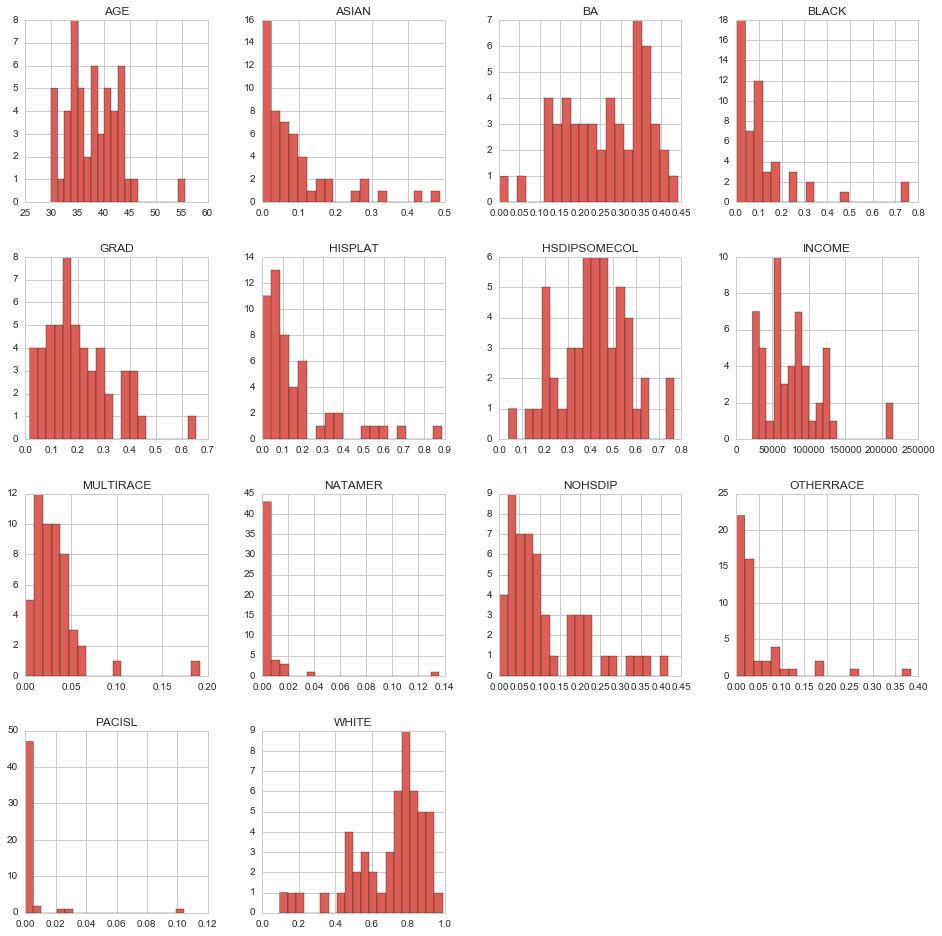

In [26]:
%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette( sns.hls_palette(n_colors=7) )
highsaleszips.hist(bins=20, figsize=(16,16), column=['INCOME','AGE','NOHSDIP','HSDIPSOMECOL','BA','GRAD','WHITE','BLACK','NATAMER','ASIAN','PACISL','OTHERRACE','MULTIRACE','HISPLAT'])

#### Education levels for zip codes in which we have sales

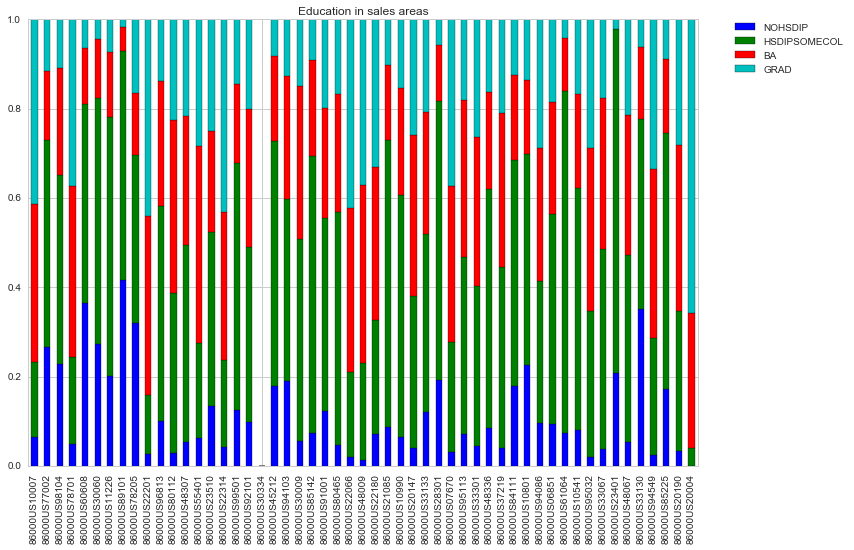

In [20]:
highsaleszips.loc[:,'NOHSDIP':'GRAD'].plot(kind='bar', stacked=True, figsize=(12,8), title='Education in sales areas')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Major racial groups for zip codes in which we have sales

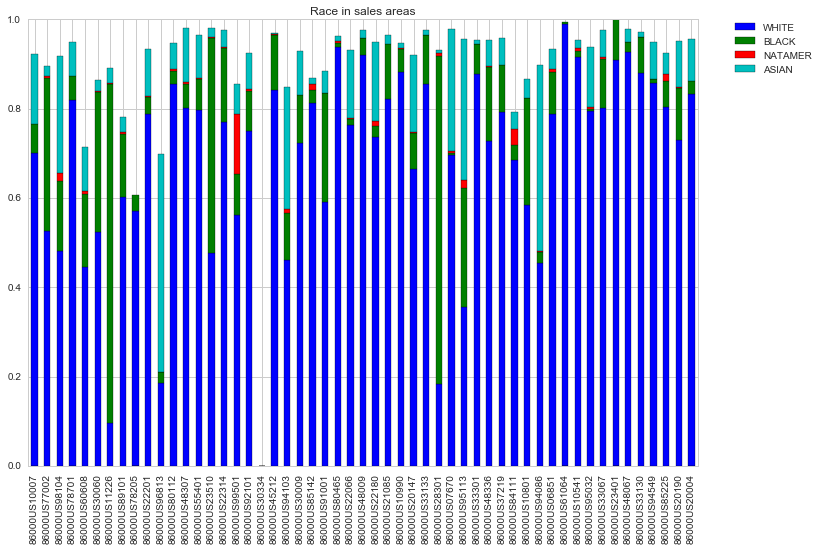

In [28]:
highsaleszips.loc[:,'WHITE':'ASIAN'].plot(kind='bar', stacked=True, figsize=(12,8), title='Race in sales areas')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [29]:
# Compare characteristics of the country as a whole to zip codes with sales
salesdiff_df = highsaleszipssum_df.sub(summary_df)
salesdiff_df

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
mean,23919.394907,-3.645351,-0.026523,-0.219417,0.120134,0.125806,-0.142454,0.046738,-0.010821,0.069549,0.002680,0.023970,0.010337,0.086894
min,19902.000000,25.900000,0.000000,0.040559,0.000000,0.016456,0.095601,0.003826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40%,13099.600000,-3.820000,-0.034500,-0.233226,0.137569,0.112301,-0.162916,0.052802,0.001435,0.037337,0.000000,0.018347,0.011962,0.061422
50%,21950.500000,-3.300000,-0.041458,-0.233619,0.153049,0.123076,-0.162181,0.071687,0.001277,0.051482,0.000000,0.018878,0.013903,0.078132
60%,29781.000000,-3.640000,-0.045903,-0.233622,0.164821,0.141581,-0.157968,0.082226,0.000542,0.066553,0.000265,0.019091,0.012111,0.083207
max,-33964.000000,-35.900000,-0.582927,-0.230769,-0.559373,-0.343357,-0.010659,-0.239410,-0.863931,-0.511710,-0.505829,-0.615610,-0.808843,-0.112787


### Conclusions

#### Incomes are much higher
Median household income overall is about $22,000 higher than the country as a whole, which is **very** significant as that represents a nearly 50% increase in income in these zip codes we sell to.

#### Education is greater
The percentage of people with high school diplomas but no college degree is almost 24% lower in our sales zips, and that is compensated by a much greater number of college grads (16% higher) and people with graduate degrees of some sort (12% higher). 

#### People are a little younger
Males and females are about 3 1/2 years younger in our zip codes than in the country as a whole.


#### White population is lower
The white population is lower, and there is a corresponding higher number of other races.



## find comparable zips

In [30]:
censusgood_df = census_df [
    ( census_df.INCOME > highsaleszipssum_df.loc['40%','INCOME'] )
    & ( census_df.INCOME < highsaleszipssum_df.loc['60%','INCOME'] )
    & ( census_df.AGE > highsaleszipssum_df.loc['40%','AGE'] )
    & ( census_df.AGE < highsaleszipssum_df.loc['60%','AGE'] )
    & ( census_df.BA > highsaleszipssum_df.loc['40%','BA'] )
    & ( census_df.BA < highsaleszipssum_df.loc['60%','BA'] )
    & ( census_df.WHITE > highsaleszipssum_df.loc['40%','WHITE'] )
    & ( census_df.WHITE < highsaleszipssum_df.loc['60%','WHITE'] )
    ]
censusgood_df.describe()

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,70446.605263,37.463158,0.075874,0.480398,0.270187,0.173540,0.768633,0.085920,0.005015,0.076523,0.000892,0.034307,0.028710,0.129219
std,6742.784887,1.088371,0.040426,0.071450,0.021725,0.067237,0.016332,0.053489,0.006879,0.045081,0.001449,0.033679,0.013181,0.103808
min,56989.000000,35.600000,0.026752,0.284136,0.240809,0.095628,0.734561,0.004204,0.000000,0.010085,0.000000,0.001946,0.005835,0.003232
25%,65683.000000,36.700000,0.054869,0.445958,0.252169,0.134817,0.758709,0.031806,0.001363,0.035986,0.000000,0.012179,0.021300,0.044803
50%,71264.500000,37.500000,0.059818,0.495970,0.266366,0.152044,0.769553,0.081308,0.002594,0.069844,0.000169,0.026639,0.023845,0.103528
75%,75855.750000,38.275000,0.083850,0.521748,0.288145,0.188011,0.782585,0.139436,0.005690,0.114887,0.001007,0.040903,0.034961,0.182670
max,81570.000000,39.200000,0.230875,0.591778,0.307421,0.399583,0.795636,0.194423,0.030930,0.174340,0.005354,0.166911,0.056916,0.400737


## Mapping great prospective zip codes

### Update data tables in CartoDB

In [31]:
#!pip install --user cartodb
# Set up cartodb module for use
from cartodb import CartoDBAPIKey, CartoDBException
API_KEY = 'dfd11d7ad9ad3f213a6336b5e878865422f624f1'
CARTODB_ACCOUNT = 'ibm'
cl = CartoDBAPIKey(API_KEY, CARTODB_ACCOUNT)

#### Update Sales table for mapping

In [32]:
# output good Census zips to a list
ziplist = highsaleszips.index.tolist()

In [33]:
# generate PostgreSQL INSERT statements for CartoDB
insertsql = ';'.join(map(lambda x: "INSERT INTO highsaleszips(zipcode) VALUES ('%s')" %x, ziplist))

In [ ]:
# update sales table
try:
    print(cl.sql('delete from highsaleszips'))
    print(cl.sql(insertsql))
except CartoDBException as e:
    print("some error ocurred", e)

#### Update prospective zip codes for mapping

In [ ]:
# output good Census zips to a list
ziplist = censusgood_df.index.tolist()

In [ ]:
# generate PostgreSQL INSERT statements for CartoDB
insertsql = ';'.join(map(lambda x: "INSERT INTO prospectzips(zipcode) VALUES ('%s')" %x, ziplist))

In [ ]:
# update prospective census zips table
try:
    print(cl.sql('delete from prospectzips'))
    print(cl.sql(insertsql))
except CartoDBException as e:
    print("some error ocurred", e)

In [ ]:
%%javascript
element.append("<link rel='stylesheet' href='http://libs.cartocdn.com/cartodb.js/v3/3.15/themes/css/cartodb.css' />")
element.append("<div id='map' style='height:500px;width:900px;padding:0;margin:0'></div>");

require.config({
  paths: {
      cartodblib: 'http://libs.cartocdn.com/cartodb.js/v3/3.15/cartodb'
  }
});

var main = function() {
  // from map: https://ibmanalytics.cartodb.com/u/ibm/viz/2bd6ea76-9f7f-11e5-a024-0e674067d321/map
  cartodb.createVis('map', 'https://ibmanalytics.cartodb.com/u/ibm/api/v2/viz/2bd6ea76-9f7f-11e5-a024-0e674067d321/viz.json', {
      shareable: true,title: true,description: true,search: true,tiles_loader: true,
      center_lat: 40, center_lon: -100, zoom: 3
  })
  .done(function(vis, layers) {
    console.log('here');
    // layer 0 is the base layer, layer 1 is cartodb layer
    // setInteraction is disabled by default
    layers[1].setInteraction(true);
    layers[1].on('featureOver', function(e, latlng, pos, data) {
      cartodb.log.log(e, latlng, pos, data);
    });
    
    var map = vis.getNativeMap(); // get the native map to work with it
    
  })
  .error(function(err) {
    console.log(err);
  });
}

require(['cartodblib'], main);


## The end